# Task: Classify X-Ray images as Covid patients, pneumonia patients, or neither

03/04/2023

[Link to GitHub repo
](https://github.com/lprockop/XrayClassification)

##### Paper providing original dataset: 
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

### Instructions

Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb  submitted to this assignment via courseworks.  Please include the link to your Github repo in this ipynb file.

Use the Covid Hackathon ipynb notebook from the Week 7 folder to import and train test split data.

In [4]:
!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 2.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
#import modules

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
#import data (stored in Drive)

import os
from google.colab import drive

drive.mount('/content/drive')

!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

#extract all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

#load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print number of images for each category
print('number of images for each category:', [len(f) for f in fnames])

#restrict number of images to first 1345 for each category
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

In [ ]:
#CREATE PREPROCESSOR

from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

#Try on single xray file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
#CREATE Y DATA

# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


In [ ]:
#train test split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

### Question 1

Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0]) #covid
im2 =preprocessor(fnames[1][0]) #normal
im3 =preprocessor(fnames[2][0]) #pneumonia
im4 =preprocessor(fnames[0][11]) #covid
im5 =preprocessor(fnames[1][11]) #normal
im6 =preprocessor(fnames[2][11]) #pneumonia
im7 =preprocessor(fnames[0][5]) #covid
im8 =preprocessor(fnames[1][5]) #normal
im9 =preprocessor(fnames[2][5]) #pneumonia

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),
                 axes_pad=0.25)

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

NameError: name 'preprocessor' is not defined

The leftmost column shows Xrays with Covid positivity, center column shows "normal" Xrays, and right column shows Xrays of patients with pneumonia. There are clear differences in lunch opacity maong the three groups.

### Question 2

Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  

Who could benefit from a model like this? Explain.

The dataset has xray image data for patients with Covid, patients with pneumonia, and "normal" patients (neither Covid nor pneumonia). The features are arrays representing images and the targets are the classification of what type of patient they are (Covid, pneumonia, or normal). 

A predictive model might be practically useful because it could help diagnose people experiencing symptoms similar to Covid or pneumonia and understand which tests and treatment methods to prioritize.

### Question 3

Run at least three prediction models to try to predict x-ray images well.
Use transfer learning for at least one of these models
* Discuss which models performed better and point out relevant hyper-parameter values for successful models.
* Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

#### Setup

In [ ]:
#ONLY AT THE TOP, INSTALL AIMODELSHARE
! pip install aimodelshare 

In [ ]:
#RESTART RUNTIME BETWEEN MODELS

import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
  y_test = pickle.load(file)

In [ ]:
#RESTART RUNTIME
#REIMPORT PREPROCESSOR 

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

#ai.export_preprocessor(preprocessor, "")

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


#### Model 1: vanilla FC NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'):
  opt = SGD(learning_rate=0.01)

  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(192, 192, 3)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=1, verbose=1, validation_data=(X_test, y_test))
  model.summary()

86/86 [==============================] - 384s 4s/step - loss: 1.2785 - accuracy: 0.5359 - val_loss: 0.6410 - val_accuracy: 0.7196
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192, 192, 64)      256       
                                                                 
 dense_1 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 dense_2 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 flatten (Flatten)           (None, 2359296)           0         
                                                                 
 dense_3 (Dense)             (None, 3)                 7077891   
                                                                 
Total params: 7,086,467
Trainable params: 7,086,467
Non-tr

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model1.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 1

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 46s 1s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 24

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
5,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
6,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
7,90.86%,90.90%,90.98%,90.86%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,19
8,89.16%,89.18%,89.79%,89.15%,keras,nan,True,Sequential,16.000000,56995.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,231216.000000,nan,sofiazaidman,11
9,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,francesyang,7


#### Model 2: basic CNN

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  
  model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs = 1, verbose=1, validation_split=.2)
  model.summary()

69/69 [==============================] - 625s 9s/step - loss: 1.1026 - accuracy: 0.3549 - val_loss: 1.0987 - val_accuracy: 0.3406
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                          

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model2.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 2

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model2.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 91s 2s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 25

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
5,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
6,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
7,90.86%,90.90%,90.98%,90.86%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,19
8,89.16%,89.18%,89.79%,89.15%,keras,nan,True,Sequential,16.000000,56995.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,231216.000000,nan,sofiazaidman,11
9,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,francesyang,7


#### Model 3: transfer learning using VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(192, 192, 3), include_top=False, weights='imagenet')

base_model.trainable = False

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

import tensorflow as tf

flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

model = Model(inputs=base_model.inputs, outputs=output)

#model.summary()

with tf.device('device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
  red_lr = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.001)

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  model.fit(X_train, y_train, batch_size=1, epochs=4, verbose=1, validation_split=0.2, callbacks=[mc, red_lr])

  model.summary()

Epoch 1/4
2192/2192 [==============================] - ETA: 0s - loss: 1.1377 - acc: 0.3317
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 1278s 583ms/step - loss: 1.1377 - acc: 0.3317 - val_loss: 1.0989 - val_acc: 0.3406 - lr: 0.0100
Epoch 2/4
2192/2192 [==============================] - ETA: 0s - loss: 1.1003 - acc: 0.3458
Epoch 00002: val_acc did not improve from 0.34062
2192/2192 [==============================] - 1271s 580ms/step - loss: 1.1003 - acc: 0.3458 - val_loss: 1.1002 - val_acc: 0.3388 - lr: 0.0100
Epoch 3/4
2192/2192 [==============================] - ETA: 0s - loss: 1.0980 - acc: 0.3312
Epoch 00003: val_acc did not improve from 0.34062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 1270s 580ms/step - loss: 1.0980 - acc: 0.3312 - val_loss: 1.1003 - val_acc: 0.3206 - lr: 0.0100
Epoch 4/4
2192/2192 [==================

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model3.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 3

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model3.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 589s 14s/step
Insert search tags to help users find your model (optional): lprockop
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 32

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
5,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
6,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
7,90.86%,90.90%,90.98%,90.86%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,19
8,90.32%,90.26%,90.28%,90.31%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,27
9,90.32%,90.26%,90.28%,90.31%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,bobbie8881,26


### Question 4

After you submit your first three models, describe your best model with your team via your team slack channel.

My best model was a fully connected neural network with accuracy 0.5359.

My team suggested increasing the number of epochs on all models. 

#### Model 4: vanilla FC NN with more epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'):
  opt = SGD(learning_rate=0.01)

  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(192, 192, 3)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=6, verbose=1, validation_data=(X_test, y_test))
  model.summary()

Epoch 1/6
86/86 [==============================] - 422s 5s/step - loss: 0.8977 - accuracy: 0.6198 - val_loss: 0.8429 - val_accuracy: 0.6514
Epoch 2/6
86/86 [==============================] - 372s 4s/step - loss: 0.5770 - accuracy: 0.7311 - val_loss: 0.5331 - val_accuracy: 0.7475
Epoch 3/6
86/86 [==============================] - 363s 4s/step - loss: 0.5095 - accuracy: 0.7753 - val_loss: 0.6692 - val_accuracy: 0.6909
Epoch 4/6
86/86 [==============================] - 366s 4s/step - loss: 0.4575 - accuracy: 0.7997 - val_loss: 0.4752 - val_accuracy: 0.7971
Epoch 5/6
86/86 [==============================] - 363s 4s/step - loss: 0.4286 - accuracy: 0.8132 - val_loss: 0.4643 - val_accuracy: 0.7878
Epoch 6/6
86/86 [==============================] - 361s 4s/step - loss: 0.3957 - accuracy: 0.8307 - val_loss: 0.4570 - val_accuracy: 0.7870
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model4.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 4

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model4.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 50s 1s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 102

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14


#### Model 5: CNN with more epochs

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  
  model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs = 6, verbose=1, validation_split=.2)
  model.summary()

Epoch 1/6
69/69 [==============================] - 630s 9s/step - loss: 0.8108 - accuracy: 0.6008 - val_loss: 0.6193 - val_accuracy: 0.7486
Epoch 2/6
69/69 [==============================] - 634s 9s/step - loss: 0.5609 - accuracy: 0.7354 - val_loss: 0.6567 - val_accuracy: 0.7614
Epoch 3/6
69/69 [==============================] - 632s 9s/step - loss: 0.4455 - accuracy: 0.8075 - val_loss: 0.4431 - val_accuracy: 0.8069
Epoch 4/6
69/69 [==============================] - 628s 9s/step - loss: 0.3531 - accuracy: 0.8581 - val_loss: 0.4108 - val_accuracy: 0.8379
Epoch 5/6
69/69 [==============================] - 623s 9s/step - loss: 0.3040 - accuracy: 0.8832 - val_loss: 0.3356 - val_accuracy: 0.8579
Epoch 6/6
69/69 [==============================] - 631s 9s/step - loss: 0.2664 - accuracy: 0.9033 - val_loss: 0.3068 - val_accuracy: 0.8852
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d 

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model5.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 5

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model5.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 99s 2s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 111

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14


#### Model 6: Transfer learning (VGG16) with more epochs

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(192, 192, 3), include_top=False, weights='imagenet')

base_model.trainable = False

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

import tensorflow as tf

flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

model = Model(inputs=base_model.inputs, outputs=output)

#model.summary()

with tf.device('device:GPU:0'):
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
  red_lr = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.001)

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  model.fit(X_train, y_train, batch_size=1, epochs=6, verbose=1, validation_split=0.2, callbacks=[mc, red_lr])

  model.summary()


#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("best_model.h5", save_format="h5")
del(model)

Epoch 1/6
2192/2192 [==============================] - ETA: 0s - loss: 1.1237 - acc: 0.3422
Epoch 00001: val_acc improved from -inf to 0.33880, saving model to best_model.h5
2192/2192 [==============================] - 1033s 471ms/step - loss: 1.1237 - acc: 0.3422 - val_loss: 1.1003 - val_acc: 0.3388 - lr: 0.0100
Epoch 2/6
2192/2192 [==============================] - ETA: 0s - loss: 1.1014 - acc: 0.3294
Epoch 00002: val_acc did not improve from 0.33880
2192/2192 [==============================] - 946s 431ms/step - loss: 1.1014 - acc: 0.3294 - val_loss: 1.1002 - val_acc: 0.3206 - lr: 0.0100
Epoch 3/6
2192/2192 [==============================] - ETA: 0s - loss: 1.1007 - acc: 0.3285
Epoch 00003: val_acc improved from 0.33880 to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 954s 435ms/step - loss: 1.1007 - acc: 0.3285 - val_loss: 1.1001 - val_acc: 0.3406 - lr: 0.0100
Epoch 4/6
2192/2192 [==============================] - ETA: 0s - loss: 1.1019 - acc: 0

In [ ]:
#SUBMIT MODEL 6

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('best_model.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})


#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 515s 13s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 217

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Question 5

Try to use augmented data to rerun at least one model and submit it to the leaderboard.
* Discuss results.

In [ ]:
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

#load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print number of images for each category
print('number of images for each category:', [len(f) for f in fnames])

#restrict number of images to first 1345 for each category
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

number of images for each category: [3616, 10192, 1345]


In [ ]:
batch_size = 128
epochs = 1
IMG_HEIGHT = 192
IMG_WIDTH = 192

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                           directory=base_path, # reading in from folder where subfolders are target names
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 42330 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(train_data_gen, epochs = 1, verbose=1)
model.summary()

331/331 [==============================] - 2656s 8s/step - loss: 1.7140e-07 - accuracy: 0.1708
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                           

In [ ]:
#SAVE MODEL OUT, DELETE MODEL OBJECT

model.save("model7.h5", save_format="h5")
del(model)

In [ ]:
#SUBMIT MODEL 7

import pickle

from aimodelshare.aimsonnx import model_to_onnx
import tensorflow as tf
model = tf.keras.models.load_model('model7.h5', compile=False)
model.compile(optimizer='adam', loss='categroical_crossentropy', metrics=['accuracy'])
onnx_model = model_to_onnx(model, framework='keras', transfer_learning=False, deep_learning=True)

with open('model.onnx', 'wb') as f:
  f.write(onnx_model.SerializeToString())

with open('X_test.pkl', 'rb') as file:
  X_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
  y_train = pickle.load(file)
    #Y TRAIN DATA IN HERE.... NOT SURE WHY IT ISN'T Y TEST.

prediction_column_index = model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = 'model.onnx', 
                        preprocessor_filepath = 'preprocessor.zip', 
                        prediction_submission = prediction_labels,
                        custom_metadata = {'team':7})

#VIEW LEADERBOARD
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

41/41 [==============================] - 18s 425ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 116

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,92.18%,92.11%,92.44%,92.17%,keras,True,True,Functional,25.000000,21867987.000000,nan,16.000000,nan,2.000000,5.000000,1.000000,nan,nan,nan,1.000000,nan,17.000000,1.000000,function,Adam,87477176.000000,7.000000,adrianwang,115


### Question 6

Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

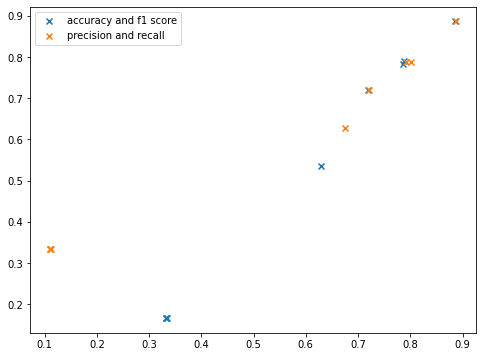

In [ ]:
import pandas as pd
leaderboard = pd.read_csv('/content/experiment-leaderboard.csv')
lp_lead = leaderboard[leaderboard['USERNAME'] == 'lprockop']
lp_lead.sort_values('F1_SCORE')

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(lp_lead.ACCURACY, lp_lead.F1_SCORE, label='accuracy and f1 score', marker='x')
plt.scatter(lp_lead.PRECISION, lp_lead.RECALL, label='precision and recall', marker='x')
plt.legend()
plt.show()

This graph shows performance metrics across all of my models.



My best model was a CNN with 5 convolutional layers. The layers were: 

Conv2D with 32 3x3 filters, using same padding and relu activation  
Conv2D with 32 1x1 filters, using same padding and relu activation  
Max pooling layer with 2x2 pooling  
Conv2D with 64 3x3 filters, using same padding and relu activation  
Conv2D with 64 1x1 filters, using same padding and relu activation  
Max pooling layer with 2x2 pooling  
Conv2D with 128 3x3 filters, using same padding and relu activation  
Conv2D with 128 1x1 filters, using same padding and relu activation  
Max pooling layer with 2x2 pooling  
Conv2D with 512 3x3 filters, using same padding and relu activation  
Conv2D with 512 1x1 filters, using same padding and relu activation  
Max pooling layer with 2x2 pooling  
Conv2D with 512 3x3 filters, using same padding and relu activation  
Conv2D with 512 1x1 filters, using same padding and relu activation  
Max pooling layer with 2x2 pooling  

Then, it was flattened and outputted using softmax to a Dense layer with 3 categories. It was trained with 6 epochs and compiled using adam optimizer and categorical crossentropy as a loss function.